Based on these posts: 
* https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
* https://github.com/keisukeirie/Amazon_review_helpfulness_prediction
* https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
* https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [2]:
!pip install -q boto3

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [4]:
!head ./amazon20000.csv

In [5]:
df = pd.read_csv('amazon20000.csv')
df.shape

(19742, 15)

In [6]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop any NaNs

In [7]:
df.shape

(19742, 15)

In [8]:
df.isna().values.any()

True

In [9]:
df_cleaned_and_filtered = df.dropna()
df_cleaned_and_filtered = df_cleaned_and_filtered.reset_index()
df_cleaned_and_filtered.shape

(19741, 16)

In [10]:
df_cleaned_and_filtered = df_cleaned_and_filtered.query('helpful_votes > 0')
df_cleaned_and_filtered.shape

(2019, 16)

In [11]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31


In [12]:
df_cleaned_and_filtered['pct_helpful_votes'] = df_cleaned_and_filtered['helpful_votes'] / df_cleaned_and_filtered['total_votes']
df_cleaned_and_filtered.shape

(2019, 17)

In [13]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000


In [14]:
df_cleaned_and_filtered['is_helpful'] = df_cleaned_and_filtered['pct_helpful_votes'] > 0.75
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True


In [15]:
df_cleaned_and_filtered['is_positive_sentiment'] = (df_cleaned_and_filtered['star_rating'] >= 4).astype(int)
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful,is_positive_sentiment
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True,1
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True,1
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True,1
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True,1
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True,0


In [16]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


## Balance the dataset

In [17]:
from sklearn.utils import resample

is_negative_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 1')

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False, # sample without replacement
                                      n_samples = len(is_negative_sentiment_df), # match minority n
                                      random_state = 27) # reproducible results

df_cleaned_and_filtered = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])


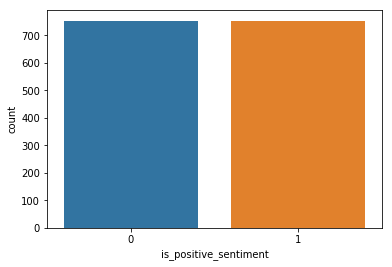

In [18]:
sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


In [46]:
X = df_cleaned_and_filtered[['review_body']]
y = df_cleaned_and_filtered['is_positive_sentiment']

print('X.shape:  {}'.format(X.shape))
print('y.shape:  {}'.format(y.shape))

X.shape:  (1506, 1)
y.shape:  (1506,)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [48]:
X_train.head(5)

,review_body
12747,This was a great movie. It was advertised as t...
18963,Thought the content was amazing and very easy ...
5956,Great viewing
5187,"Fascinating story, superb acting."
4410,I have always loved Bugs Bunny since I was a k...


In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [50]:
import nltk
import re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [60]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

feature_union = FeatureUnion([
        ('body', Pipeline([
            ('body_text_selector', TextSelector('review_body')),
            ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ]))
])

X_train_transformed = feature_union.fit_transform(X_train)

# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_train_new_pd = pd.DataFrame(X_train_transformed)
X_train_new_pd.insert(0, 'is_positive_sentiment', y_train)
X_train_new_pd = X_train_new_pd.fillna(0)

X_train_new_pd.head(5)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.225930,0.047559,-0.073514,-0.060542,0.060575,0.015665,0.132203,0.061457,-0.009799,...,0.040697,-0.019271,0.032049,0.006005,-0.056281,0.047888,-0.026335,-0.011817,0.014283,-0.050853
1,0.0,0.156836,-0.021323,-0.014008,-0.024390,-0.078827,0.119074,-0.047081,-0.000745,-0.029771,...,-0.052166,0.002046,0.040383,0.004632,-0.012791,-0.024409,0.012041,-0.007966,-0.029290,-0.015633
2,1.0,0.159726,0.442852,-0.000187,-0.031316,0.030073,0.024673,-0.007520,-0.007541,0.024945,...,-0.074270,0.012252,-0.072675,0.029161,-0.023723,0.043194,0.030401,-0.009014,-0.005237,0.040605
3,0.0,0.085095,-0.010017,-0.012378,-0.011187,-0.041756,0.014018,-0.052679,-0.002091,-0.016649,...,-0.056030,0.053759,0.000466,0.026937,0.050955,0.000880,0.012281,-0.025400,0.029062,0.006524
4,0.0,0.108459,-0.024930,-0.039093,0.113266,-0.011156,-0.025582,0.045436,-0.003395,-0.028733,...,0.001113,-0.016682,-0.012797,0.012588,0.017718,0.007830,-0.000277,0.052339,-0.032722,0.003917


In [65]:
X_train_new_pd.to_csv('train_transformed.csv', index=False, header=False)

In [66]:
X_test_transformed = feature_union.fit_transform(X_test)

# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_test_new_pd = pd.DataFrame(X_test_transformed)
X_test_new_pd.insert(0, 'is_positive_sentiment', y_test)
X_test_new_pd = X_test_new_pd.fillna(0)

X_test_new_pd.head(5)


,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,141,142,143,144,145,146,147,148,149,150
0,0.0,0.037893,0.013902,0.119463,-0.033234,-0.069295,-0.112359,0.099121,-0.017358,0.075342,...,-0.008690,-0.005268,0.006514,0.000423,0.002800,-0.001583,0.011717,-0.001775,2.744948e-54,8.063658e-53
1,0.0,0.000783,0.000338,0.004056,-0.001736,-0.002519,-0.005495,-0.001307,0.002230,-0.003647,...,0.001279,-0.000116,-0.000293,0.000553,-0.000062,0.000198,-0.000007,0.000116,3.617082e-33,2.923048e-38
2,0.0,0.094975,-0.019371,0.126114,0.126790,-0.004527,-0.023208,-0.005550,-0.038828,0.023118,...,0.036220,0.016168,-0.001649,0.001699,-0.005724,0.010953,-0.000260,0.015875,5.044030e-32,1.917838e-38
3,0.0,0.683610,-0.266067,-0.031108,0.257051,0.107093,0.061684,0.013273,0.020912,-0.035731,...,0.051758,-0.024997,0.003058,0.003664,0.044213,-0.229039,0.000656,0.353665,-6.100951e-32,1.526891e-37
4,0.0,0.017973,0.005229,0.074666,-0.018678,-0.003285,-0.039996,-0.003280,0.021635,-0.045030,...,0.003400,0.007100,0.000900,0.025801,0.002001,0.003815,-0.000535,-0.005218,-2.606616e-32,2.185896e-37


In [67]:
X_test_new_pd.to_csv('validation_transformed.csv', index=False, header=False)

In [72]:
prefix = 'sagemaker/xgboost/data'

# The Amazon SageMaker implementation of XGBoost supports CSV formats for training and inference
# For Training ContentType, valid inputs `text/csv`.

train_data_uri = sess.upload_data(path="train_transformed.csv", key_prefix=prefix + "/training")
validation_data_uri = sess.upload_data(path="validation_transformed.csv", key_prefix=prefix + "/validation")

print(train_data_uri)
print(validation_data_uri)

s3_input_train_data = sagemaker.s3_input(s3_data=train_data_uri, content_type='text/csv')
s3_input_validation_data = sagemaker.s3_input(s3_data=validation_data_uri, content_type='text/csv')


s3://sagemaker-us-east-1-835319576252/sagemaker/xgboost/data/training/train_transformed.csv
s3://sagemaker-us-east-1-835319576252/sagemaker/xgboost/data/validation/validation_transformed.csv


In [75]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 

# get the URI for new container
builtin_container_uri = get_image_uri(region_name=region,                                
                                  repo_name='xgboost', 
                                  repo_version='0.90-2')

model_output_path = 's3://{}/sagemaker/xgboost/training-runs'.format(bucket)

xgb_estimator = sagemaker.estimator.Estimator(image_name=builtin_container_uri, 
                                              role=role, 
                                              hyperparameters={'num_round': 1,
                                                               'max_depth': 5},
                                                               #'learning_rate': 0.01},
                                              train_instance_count=1, 
                                              train_instance_type='ml.m4.xlarge', 
                                              output_path=model_output_path, 
                                              sagemaker_session=sess);
xgb_estimator.fit({'train': s3_input_train_data, 'validation': s3_input_validation_data}
                  #, wait=False
                 )

2020-02-28 22:55:09 Starting - Starting the training job...
2020-02-28 22:55:10 Starting - Launching requested ML instances......
2020-02-28 22:56:15 Starting - Preparing the instances for training......
2020-02-28 22:57:34 Downloading - Downloading input data
2020-02-28 22:57:34 Training - Downloading the training image...
2020-02-28 22:58:09 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[22:58:06] 1355x300 matrix with 406500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV input is ','
[22:58:06] 151x151 matrix with 22801 ent


2020-02-28 22:58:16 Failed - Training job failed


UnexpectedStatusException: Error for Training job sagemaker-xgboost-2020-02-28-22-55-09-213: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.6/site-packages/sagemaker_xgboost_container/algorithm_mode/train.py", line 196, in train_job
    verbose_eval=False)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/training.py", line 32, in _train_internal
    bst = Booster(params, [dtrain] + [d[0] for d in evals])
  File "/miniconda3/lib/python3.6/site-packages/xgboost/core.py", line 941, in __init__
    self._validate_features(d)
  File "/miniconda3/lib/python3.6/site-packages/xgboost/core.py", line 1690, in _validate_features
    data.feature_names))
ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34'

In [ ]:
training_job_name = xgb_estimator.latest_training_job.name
print('training_job_name:  {}'.format(training_job_name))

In [ ]:
# TODO:  This is broken
#from sagemaker.xgboost import XGBoost

#xgb_estimator = XGBoost.attach(training_job_name=training_job_name)

# Deploy Endpoint

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='ml.m4.xlarge',
                     endpoint_name=xgb_endpoint_name)

In [ ]:
predictions, raw_outputs = model.predict(["""Very funny. A typical mid 50's comedy."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))

In [ ]:
predictions, raw_outputs = bert_model.predict(["""That movie was absolutely awful."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))